<a href="https://colab.research.google.com/github/fastdatascience/clinical_trial_risk/blob/fixes_nov_2022/train/ctgov/TrainSAPClassifier_03_NaiveBayes_fixed_vocab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import spacy
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_annotations = pd.read_csv("/content/drive/MyDrive/data/all_annotations.csv")


# Get data

In [36]:
stats_vocab = set("""0	pe
1	sap
2	tabulated
3	hazard
4	inferiority
5	categorical
6	meddra
7	residual
8	itt
9	continuous
10	summarised
11	variables
12	brv
13	variable
14	cox
15	listings
16	laz
17	statistics
18	descriptive
19	regression
20	proportional
21	hazards
22	sided
23	deviation
24	presented
25	corresponding
26	percentage
27	calculated
28	analysed
29	censored
30	derived
31	coding
32	cumulative
33	seroconversion
34	soc
35	tables
36	proportion
37	dapivirine
38	covariates
39	survival
40	deviations
41	pv
42	interim
43	class
44	hypothesis
45	sensitivity
46	power
47	ratio
48	summarized
49	median
50	measurements
51	model
52	endpoint
53	exploratory
54	statistical
55	plan
56	confidence
57	log
58	ipm
59	estimate
60	planned
61	demographic
62	classified
63	95%
64	solicited
65	iu
66	significance
67	adjusted
68	pq
69	randomisation
70	ci
71	values
72	differences
73	measures
74	signed
75	outcomes
76	assigned
77	analyses
78	overview
79	intervals
80	randomised
81	measurement
82	90%
83	versus
84	analysis
85	point
86	adherence
87	interval
88	secondary
89	value
90	groups
91	estimated
92	mean
93	relative
94	treat
95	frequency
96	outcome
97	detect
98	discharge
99	distribution
100	baseline
101	endpoints
102	dsmb
103	objectives
104	efficacy
105	method
106	negative
107	concentration
108	assessed
109	confirmed
110	table
111	fluid
112	ae
113	rate
114	death
115	stopping
116	cd
117	self
118	otherwise
119	parameters
120	maximum
121	compared
122	multiple
123	crf
124	type
125	general
126	incidence
127	defined
128	function
129	50%
130	scheduled
131	considerations
132	methods
133	reported
134	expected
135	period
136	meeting
137	details
138	first
139	aes
140	occurring
141	doses
142	rates
143	count
144	received
145	completed
146	relationship
147	status
148	occurrence
149	placebo
150	specified
151	upper
152	vs
153	window
154	total
155	database
156	effect
157	determined
158	every
159	saes
160	fever
161	individual
162	comparison
163	vital
164	duration
165	allocation
166	concentrations
167	infant
168	discontinuation
169	one
170	higher
171	list
172	tq
173	two
174	assessments
175	reason
176	based
177	given
178	observed
179	version
180	measure
181	lower
182	three
183	history
184	assess
185	either
186	result
187	range
188	enrolled
189	visits
190	grade
191	positive
192	weeks
193	performed
194	system
195	hb
196	visit
197	changes
199	serious
200	whether
201	culture
202	design
203	reasons
204	findings
205	test
206	follow
207	cells
208	dose
209	events
210	concomitant
211	description
212	include
213	pre
214	without
215	tests
216	measured
217	evaluation
218	conducted
219	exclusion
220	addition
221	specific
222	presence
223	compliance
224	single
225	sub
226	low
227	different
228	less
229	weekly
230	prior
231	safety
232	normal
233	day
234	early
235	described
236	event
237	conditions
238	section
239	standard
240	results
241	adverse
242	provided
243	identified
244	taken
245	order
246	prevalence
250	independent
251	immediate
252	calcium
254	available
255	receiving
256	handling
257	product
258	inclusion
259	person
260	known
261	years
262	page
263	controlled
264	also
265	sample
266	according
267	well
269	related
270	randomization
271	blind
272	exposure
273	evaluate
274	report
275	following
276	protection
277	loss
279	benefit
280	monitoring
281	active
282	criteria
283	examination
284	evaluated
285	dl
286	similar
287	tract
288	final
289	resistance
290	document
291	infection
292	determine
293	withdrawal
294	associated
295	physical
296	respiratory
297	refer
298	moderate
299	subsequent
300	medication
301	severe
302	full
303	additional
305	screening
306	recorded
307	high
308	abnormal
309	tested
310	failure
311	assessment
312	control
313	randomized
314	completion
315	within
316	treated
318	social
319	reaction
320	signs
321	mm
322	due
323	temperature
324	regimen
325	sae
326	reduction
327	immune
328	made
329	illness
330	collected
331	diagnosis
332	reporting
333	significant
334	responses
335	meet
336	therefore
337	detailed
338	since
339	symptoms
340	acceptability
341	double
342	assay
343	would
344	previous
345	documented
346	risk
347	appropriate
348	starting
349	potential
350	administered
351	evidence
352	amendment
353	possible
354	complete
355	selected
356	including
357	note
359	increase
360	eligible
362	individuals
363	reports
365	acute
366	initial
367	serum
368	required
369	hours
370	support
372	followed
373	antibody
374	investigational
377	cause
379	form
381	receive
385	current
386	obtained
387	blood
388	alt
389	clinic
390	review
392	approximately
393	committee
394	50
396	administration
397	dosing
398	procedure
399	occur
400	applicable
401	effects
402	change
403	participation
404	oral
405	threatening
406	impact
407	response
408	testing
409	approved
410	provide
412	child
413	enrollment
414	site
415	important
416	volume
417	daily
419	mortality
421	reactions
422	ensure
423	procedures
424	samples
425	contact
426	95
428	ab
431	quality
432	therapy
433	clinically
434	development
435	limited
436	activity
437	local
438	could
439	written
440	approval
441	indicated
442	conduct
443	entry
445	sampling
446	home
447	90
448	forms
450	process
451	ml
452	consent
454	long
456	intervention
457	countries
458	staff
459	informed
460	specimen
461	continue
462	records
463	text
464	med
465	management
467	field
469	risks
470	collection
471	guidelines
472	need
473	documents
474	questions
477	record
478	access
479	studies
482	requirements
486	care
487	national
488	drugs
489	stored
490	55
491	specimens
492	monitor
493	counselling
494	transmission
495	storage
496	center
497	pd
498	art
499	ls""".split("\n"))
stats_vocab = set([re.sub(r'\d+\s+', '', w) for w in stats_vocab])

In [37]:
tok = RegexpTokenizer(r'[a-zA-Z]+')

In [38]:
with open("/content/drive/MyDrive/data/protocols.pkl.gz", "rb") as f:
    file_to_pages = pkl.load(f)

In [39]:
import operator
texts = []

for i in range(len(df_annotations)):
    file_name = df_annotations.file.iloc[i]
    
    pages= file_to_pages[file_name]

    texts.append(" ".join(pages))
df_annotations["text"] = texts

In [40]:
 del file_to_pages

In [41]:
df_annotations = df_annotations[~df_annotations.has_sap.isna()]

In [42]:
df_annotations["has_sap"].value_counts()

0    6150
1    5774
Name: has_sap, dtype: int64

In [43]:
df_train = df_annotations[df_annotations.train_val == "train"]
df_val = df_annotations[df_annotations.train_val == "val"]

In [44]:

# Specially engineered regex to include 95%, 95%ci, etc
vectoriser = CountVectorizer(lowercase=True, vocabulary=stats_vocab, min_df=5,
                             token_pattern=r'[59][05]%?(?:ci)?|[a-z][a-z]+')
transformer = TfidfTransformer()

nb = MultinomialNB()
model = make_pipeline(vectoriser, transformer, nb)

In [45]:
df_train_small = df_train.sample(100)

In [46]:
model.fit(df_train_small.text, df_train_small.has_sap)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(min_df=5,
                                 token_pattern='[59][05]%?(?:ci)?|[a-z][a-z]+',
                                 vocabulary={'50', '50%', '55', '90', '90%',
                                             '95', '95%', 'ab', 'abnormal',
                                             'acceptability', 'access',
                                             'according', 'active', 'activity',
                                             'acute', 'addition', 'additional',
                                             'adherence', 'adjusted',
                                             'administered', 'administration',
                                             'adverse', 'ae', 'aes',
                                             'allocation', 'also', 'alt',
                                             'amendment', 'analysed',
                                             'analyses', ...})),
                ('tfidftransf

In [51]:
df_val["y_pred"] = model.predict(df_val.text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [52]:
df_val["y_pred_proba"] = model.predict_proba(df_val.text)[:,1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [53]:
sap_ground_truths = df_val.has_sap
pred_sap = df_val.y_pred

In [54]:
acc = accuracy_score(sap_ground_truths, pred_sap)
print (f"SAP accuracy {acc}")

SAP accuracy 0.7990783410138249


''

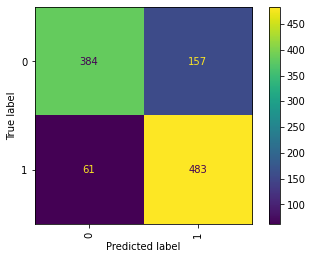

In [55]:
ConfusionMatrixDisplay.from_predictions(sap_ground_truths, pred_sap)
plt.xticks(rotation=90)
;

In [56]:
all_aucs = []
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(sap_ground_truths, pred_sap)
print (f"SAP ROC AUC {roc_auc}")

SAP ROC AUC 0.7988321599434598


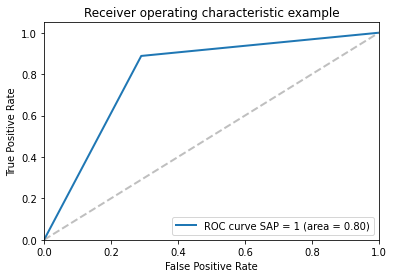

In [57]:
plt.figure()
lw = 2
    
for i in [1]:
    fpr, tpr, _ = roc_curve(sap_ground_truths, pred_sap)
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        # color="darkorange",
        lw=lw,
        label=f"ROC curve SAP = {i} (area = {roc_auc:0.2f})"
    )
    plt.plot([0, 1], [0, 1], color="gray", alpha=0.5, lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [58]:
fake_document = " ".join(vectoriser.vocabulary_)
vectorised_document = vectoriser.transform([fake_document])
transformed_document = transformer.transform(vectorised_document)
probas = np.zeros((transformed_document.shape[1]))

for prediction_idx in [1]:
      print(f"Strongest predictors for class {prediction_idx}\n")
      for i in range(transformed_document.shape[1]):
          zeros = np.zeros(transformed_document.shape)
          zeros[0, i] = transformed_document[0, i]
          proba = nb.predict_log_proba(zeros)
          probas[i] = proba[0, prediction_idx]

      for ctr, j in enumerate(np.argsort(-probas)):
          for w, i in vectoriser.vocabulary_.items():
              if i == j:
                  print(f"{ctr}\t{w}")


Strongest predictors for class 1

0	ab
1	specimens
2	discharge
3	effects
4	specimen
5	culture
6	dsmb
7	ci
8	center
9	cells
10	low
11	cumulative
12	soc
13	risk
14	versus
15	procedure
16	outcomes
17	function
18	stored
19	art
20	risks
21	estimate
22	field
23	studies
24	mortality
25	iu
26	less
27	survival
28	intervention
29	med
30	standard
31	effect
32	given
33	rates
34	would
35	determine
36	adverse
37	normal
38	therapy
39	two
40	response
41	plan
42	also
43	outcome
44	hypothesis
45	55
46	support
47	monitoring
48	dl
49	care
50	responses
51	hours
52	whether
53	compared
54	groups
55	consent
56	evidence
57	randomized
58	well
59	pq
60	current
61	without
62	child
63	incidence
64	power
65	weeks
66	50
67	reported
68	general
69	90
70	associated
71	early
72	high
73	95
74	individuals
75	within
76	national
77	acute
78	initial
79	significant
80	addition
81	pre
82	blood
83	could
84	treated
85	need
86	assess
87	include
88	loss
89	reporting
90	staff
91	distribution
92	regression
93	cd
94	measure
95	based


In [59]:
import bz2
with bz2.open("sap_classifier_document_level.pkl.bz2", "wb") as f:
    pkl.dump(model, f)